# Maman 22

## Import Libraries

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preproccesing from maman 21

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/chronic_kidney_disease.csv')
df = df.drop(columns=['rbc', 'wbcc', 'rbcc'], axis=1)
numeric_col = ['age', 'bp', 'sg', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv']
category_col = ['al', 'su', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
for col in numeric_col:
  df[col] = df[col].fillna(df[col].mean())
for col in category_col:
  df[col] = df[col].fillna(df[col].mode()[0])

le = LabelEncoder()
for col in category_col:
    df[col] = le.fit_transform(df[col])

## split data set to train and validation

In [ ]:
x = df.drop(columns=['class'], axis=1)
y = train = df['class']

#oversample = SMOTE(k_neighbors=4)
# transform the dataset
#x, y = oversample.fit_resample(x, y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Classification

## Naive Bayes Algorithm:

In [ ]:
nb = GaussianNB()
cv = cross_val_score(nb,X_train,y_train,cv=5)
print(cv.mean())

0.959375


In [ ]:
nb.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = nb.predict(X_test)

# Calculate the probabilities for ROC AUC
y_prob = nb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_test, y_prob)
confusion_mat = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Model score for the algorithm Naive Bayes:")
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", confusion_mat)
print("F1 Score:", f1)

Model score for the algorithm Naive Bayes:
ROC AUC: 0.9903846153846153
Confusion Matrix:
 [[51  1]
 [ 0 28]]
F1 Score: 0.9824561403508771


## KNN:

In [ ]:
#K neighbors
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv.mean())

0.85625


In [ ]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)

# Train the model
knn.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Calculate the probabilities for ROC AUC
y_prob = knn.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_test, y_prob)
confusion_mat = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model score for the algorithm k-NN:")
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", confusion_mat)
print("F1 Score:", f1)

Model score for the algorithm k-NN:
ROC AUC: 0.9821428571428571
Confusion Matrix:
 [[48  4]
 [ 0 28]]
F1 Score: 0.9333333333333333


# Q2

## Init K-Means and data + functions

In [ ]:
from typing import Union
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import homogeneity_score, completeness_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_ckd_dist(X: pd.DataFrame) -> list:
    return X.groupby('Class')['clusters'].apply(list)

In [ ]:
def get_score_info(est: Union[KMeans, DBSCAN], n_clusters, X, labels, y, n_noise_=None, metric='euclidean') -> str:
    info = []
    if n_noise_:
        info.append(f'noise: {n_noise_}')
    info.append(f'number of clusters: {n_clusters}')
    h, c, v = metrics.homogeneity_completeness_v_measure(y, labels)
    info.append(f'homogeneity score: {h}')
    sill = 0
    if n_clusters > 1:
        sill = metrics.cluster.silhouette_score(X, labels)
        info.append(f'silhouette score: {sill}')
    return '\n'.join(info), sill, h

In [ ]:
def elbow(X):
    scores = []
    for init_method in ['random', 'k-means++']:
        clusters = range(1, 30)
        for k in clusters:
            kmeans = KMeans(init=init_method, n_clusters=k, random_state=10)
            scores.append(kmeans.fit(X).inertia_)
        plt.plot(clusters, scores, marker='o')
        plt.title(f'Elbow Method for using {init_method} init method')
        plt.xticks(clusters)
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()
        scores = []

In [ ]:
def get_bins(df, n, encode, strat):
    global numeric_col
    binner = KBinsDiscretizer(n_bins=n, encode=encode, strategy=strat)
    X = pd.DataFrame(binner.fit_transform(df[numeric_col]))
    X.columns = numeric_col
    for cat in category_col:
        X[cat] = df[cat]
    return X

In [ ]:
def run_kmeans2(X: pd.DataFrame, y, clusters, rs):
    kms = []
    for init_method in ['random', 'k-means++']:
        for k in clusters:
            data = X.copy()
            kmeans = KMeans(n_clusters=k, init=init_method, random_state=rs)
            data['clusters'] = kmeans.fit_predict(data)
            reduced_data = PCA(n_components=2).fit_transform(data)
            results = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])

            score_info, sill, h = get_score_info(kmeans, k, results, data['clusters'], y)
            plt.figure(figsize=(7, 7))
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
            sns.scatterplot(x='PCA1', y='PCA2', hue=kmeans.labels_, data=results)
            ax = plt.gca()
            ax.grid(False)
            plt.text(0.33, -0.15, score_info, transform=ax.transAxes, verticalalignment='top', bbox=props)
            plt.title(f'K-means Clustering with k={k} and {init_method} init')
            plt.show()
        kms.append(data)

    return kms

In [ ]:
def run_kmeans(X: pd.DataFrame, y, k_random, k_kpp, random_state):
    kms = []
    for k, init_method in zip([k_random, k_kpp], ['random', 'k-means++']):
        data = X.copy()
        kmeans = KMeans(n_clusters=k, init=init_method, random_state=random_state)
        data['clusters'] = kmeans.fit_predict(data)
        # we need to perform a linear transormation in order to plot it in R^2
        reduced_data = PCA(n_components=2).fit_transform(data)
        results = pd.DataFrame(reduced_data, columns=['PCA1', 'clusters'])

        score_info, sill, h = get_score_info(kmeans, k, results, data['clusters'], y)
        plt.figure(figsize=(7, 7))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        sns.scatterplot(x='PCA1', y='clusters', hue=kmeans.labels_, data=results)
        ax = plt.gca()
        ax.grid(False)
        plt.text(0.33, -0.15, score_info, transform=ax.transAxes, verticalalignment='top', bbox=props)
        plt.title(f'K-means Clustering with k={k} and {init_method} init')
        plt.show()
        kms.append(data)

    return kms

## Elbow method on df

In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


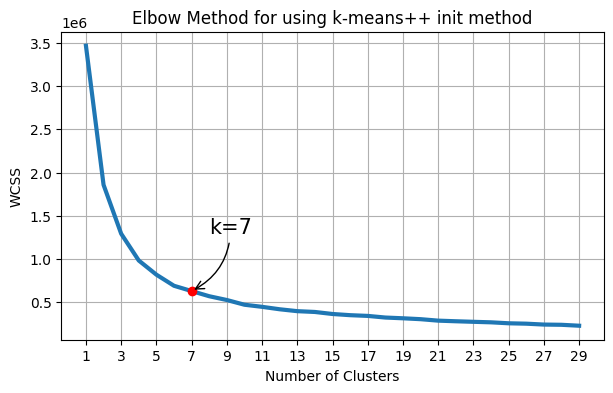

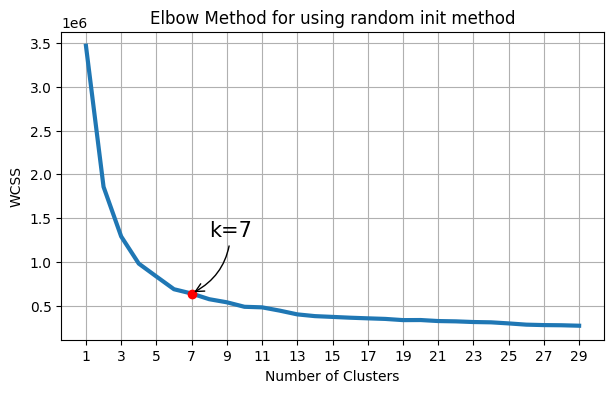

In [ ]:
X1 = df.copy()
from kneed import KneeLocator
def plot_elbow_and_return_k(X: pd.DataFrame) -> list:
    """ returns the best K(s) param after testing for both k++ and random init"""
    sse, knees = [], {}
    clusters = range(1, 30)
    for init_method in ['k-means++', 'random']:
        for k in clusters:
            kmeans = KMeans(n_clusters=k, random_state=42, init=init_method)
            kmeans.fit(X)
            sse.append(kmeans.inertia_)
        knee = KneeLocator(clusters, sse, curve="convex", direction="decreasing").elbow + 1
        plt.figure(figsize=(7, 4))
        plt.title(f'Elbow Method for using {init_method} init method')
        plt.xticks(range(1, 30, 2))
        plt.grid(True)
        plt.plot(clusters, sse, linewidth=3)
        plt.xlabel("Number of Clusters")
        plt.ylabel("WCSS")
        plt.plot(knee, sse[knee-1], 'ro')
        ax = plt.gca()
        ap = {'arrowstyle': "->", 'connectionstyle': 'arc3,rad=-0.3'}
        ax.annotate(f'k={knee}', (knee, sse[knee-1]), (knee+1, sse[knee-5]), arrowprops=ap, fontsize=15)
        plt.show()
        sse = []
        knees[init_method] = knee
    return knees

knees = plot_elbow_and_return_k(X1)

## K-Means
### epsilon determination

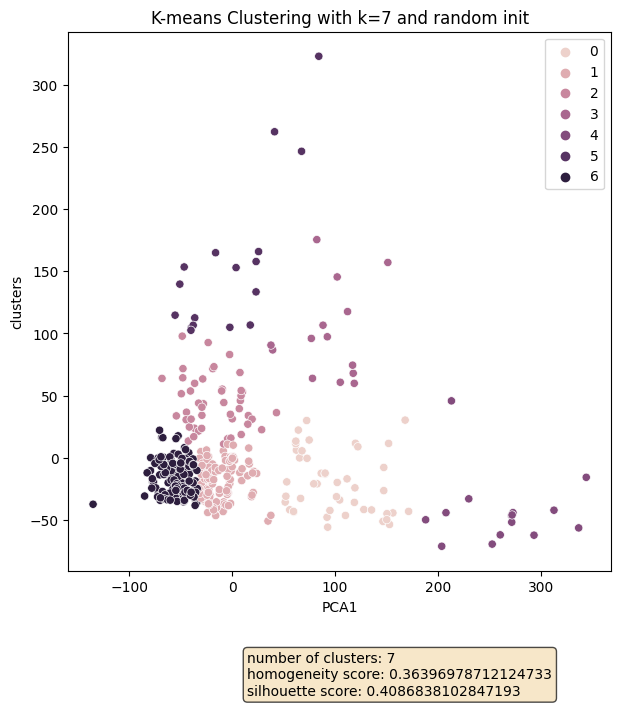

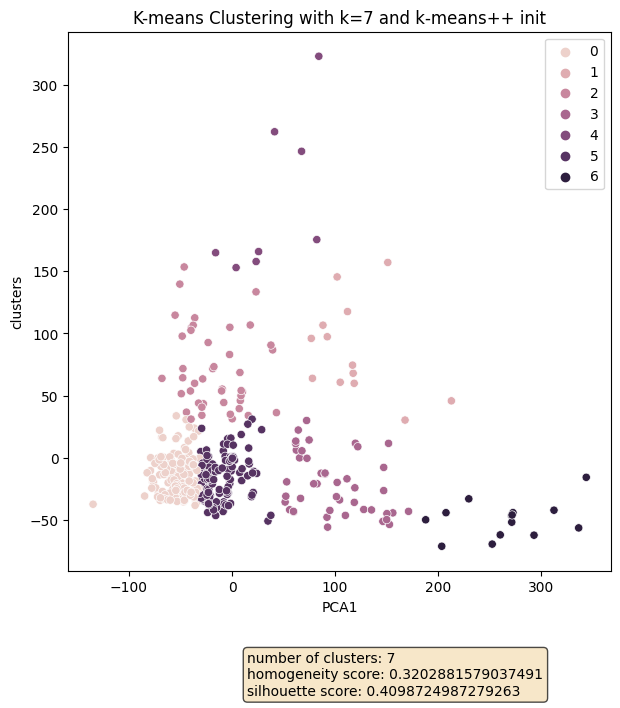

In [ ]:
X1, y1 = df.copy(), df['class']
k_random, k_kpp, random_state = knees['random'], knees['k-means++'], 42
r, k = run_kmeans(X1, y1, k_random, k_kpp, random_state)

## DBSCAN
### epsilon determination

In [ ]:
from sklearn.neighbors import NearestNeighbors
def plot_nn_for_eps(df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.title(f'Nearest-Neighbours')
    plt.show()

def get_reduced(df: pd.DataFrame, components):
    data = PCA(n_components=components).fit_transform(df)
    data = pd.DataFrame(data, columns=[f'pca{i}' for i in range(1, components+1)])
    return data

In [ ]:
def run_dbscan(X: pd.DataFrame, y, e, n_e, components=2):
    dbs = []
    for metric in ['euclidean', 'manhattan']:
        data = X.copy()
        # init dbscan
        data = get_reduced(data, components)
        dbscan = DBSCAN(eps=e, min_samples=n_e, metric=metric)
        # fit prdict
        data['clusters'] = dbscan.fit_predict(data)
        dbs.append(data)
        # get labels to get noise and n_clusters
        labels = dbscan.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        hom, comp = homogeneity_score(y, data['clusters']), completeness_score(y, data['clusters'])
        # reduction for R^2
        results = get_reduced(data, 2)
        reduced_X = PCA(n_components=2).fit_transform(data)
        results = pd.DataFrame(reduced_X, columns=['pca1','pca2'])
        # get score and info
        score_info, sill, h = get_score_info(dbscan, n_clusters_, data, labels, y, n_noise_=n_noise_)
        plt.figure(figsize=(7, 7))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        sns.scatterplot(x='pca1', y='pca2', hue=labels, data=results, legend='full')
        ax = plt.gca()
        plt.text(0.33, -0.15, score_info, transform=ax.transAxes, verticalalignment='top', bbox=props)
        plt.title(f'DBSCAN with {n_clusters_} clusters, epsilon={e}, N_e(x)={dbscan.min_samples}, metric={metric}')
        plt.show()
    return dbs

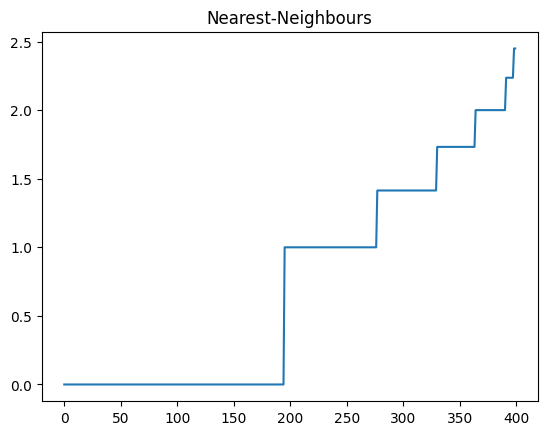

In [ ]:
n_bins = 2
X2 = get_bins(df, n_bins, 'ordinal', 'uniform')
plot_nn_for_eps(X2)

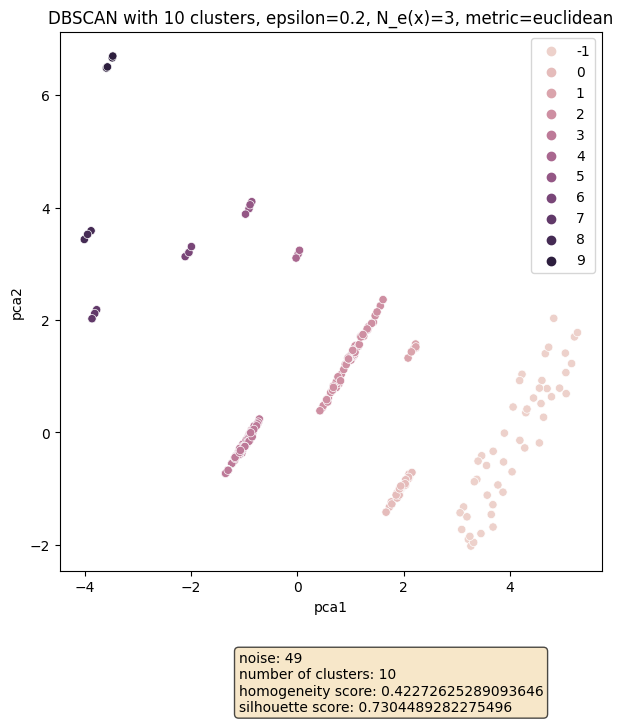

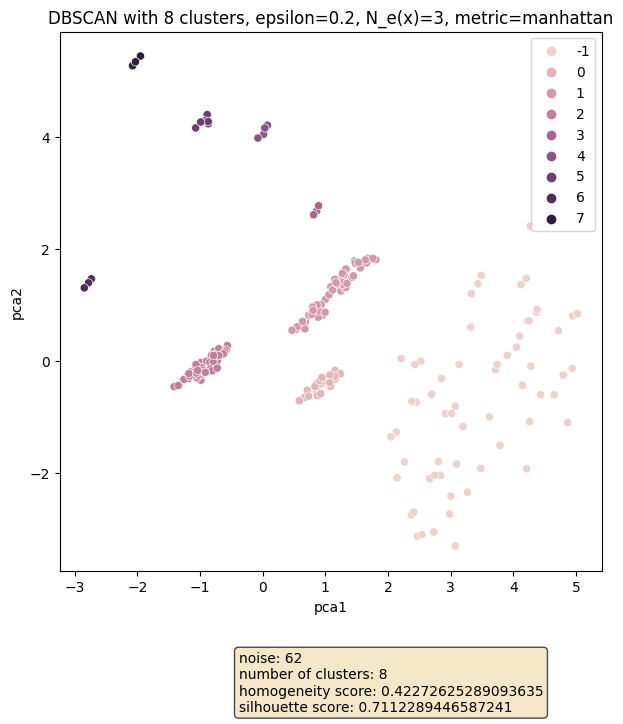

[         pca1      pca2  clusters
 0    0.074151 -0.213397         0
 1    2.057245 -1.631341         1
 2    2.400309  1.922628        -1
 3    2.957449 -1.822497        -1
 4    0.646810 -0.771017         2
 ..        ...       ...       ...
 395 -1.275630  0.036062         3
 396 -1.354516 -0.012260         3
 397 -1.354516 -0.012260         3
 398 -1.354516 -0.012260         3
 399 -1.275630  0.036062         3
 
 [400 rows x 3 columns],
          pca1      pca2  clusters
 0    0.074151 -0.213397         0
 1    2.057245 -1.631341         5
 2    2.400309  1.922628        -1
 3    2.957449 -1.822497        -1
 4    0.646810 -0.771017         1
 ..        ...       ...       ...
 395 -1.275630  0.036062         2
 396 -1.354516 -0.012260         2
 397 -1.354516 -0.012260         2
 398 -1.354516 -0.012260         2
 399 -1.275630  0.036062         2
 
 [400 rows x 3 columns]]

In [ ]:
epsilon, neighbours, components = .2, 3, 2
run_dbscan(X2, y1, epsilon, neighbours, components)

# Q3 - Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
print(X_train.shape[1])

21


In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1408      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
8/8 [==============================] - 1s 35ms/step - loss: 3.4798 - accuracy: 0.5703 - val_loss: 3.0835 - val_accuracy: 0.5938
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 1.7050 - accuracy: 0.6719 - val_loss: 0.7954 - val_accuracy: 0.7969
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 1.1227 - accuracy: 0.7383 - val_loss: 0.6399 - val_accuracy: 0.8438
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7281 - accuracy: 0.7773 - val_loss: 0.6120 - val_accuracy: 0.7656
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5451 - accuracy: 0.8281 - val_loss: 0.4713 - val_accuracy: 0.8281
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.3771 - accuracy: 0.8672 - val_loss: 0.5251 - val_accuracy: 0.8125
Epoch 7/50
8/8 [==============================] - 0s 11ms/step - loss: 0.3139 - accuracy: 0.8594 - val_loss: 0.3170 - val_accuracy: 0.8594
Epoch 8/50
8/8 [============

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3/3 [==============================] - 0s 5ms/step - loss: 0.0645 - accuracy: 0.9750
Test accuracy: 0.9750000238418579


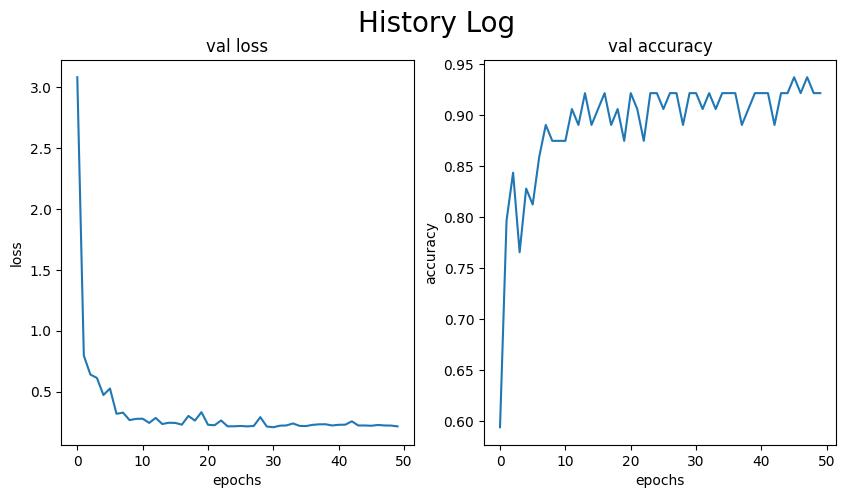

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)

axs[0].plot(history.history['val_loss'])
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].set_title('val loss')

axs[1].plot(history.history['val_accuracy'])
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].set_title('val accuracy')

plt.show()

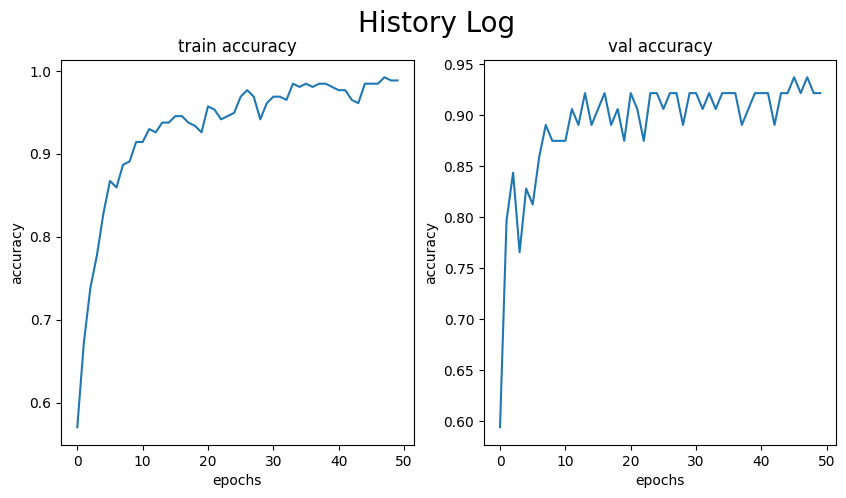

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)

axs[0].plot(history.history['accuracy'])
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")
axs[0].set_title('train accuracy')

axs[1].plot(history.history['val_accuracy'])
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].set_title('val accuracy')

plt.show()

### ROC AUC

3/3 [==============================] - 0s 31ms/step


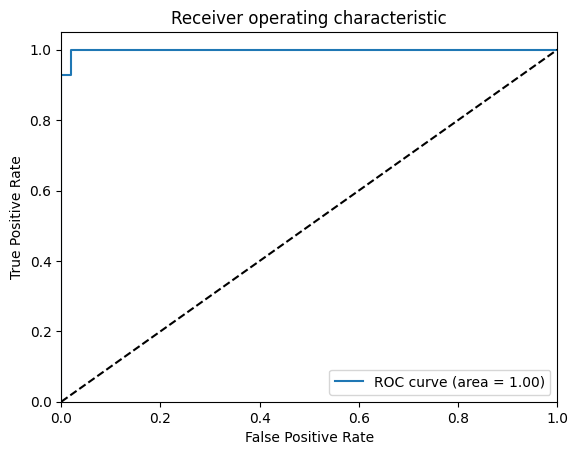

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred = model.predict(X_test)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def trans(numbers):
  transformed_numbers = []
  for number in numbers:
    if number < 0.5:
      transformed_numbers.append(0)
    else:
      transformed_numbers.append(1)
  return transformed_numbers
y_pred= trans(y_pred)
print(y_pred)

[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]


In [ ]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.975


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[50  2]
 [ 0 28]]


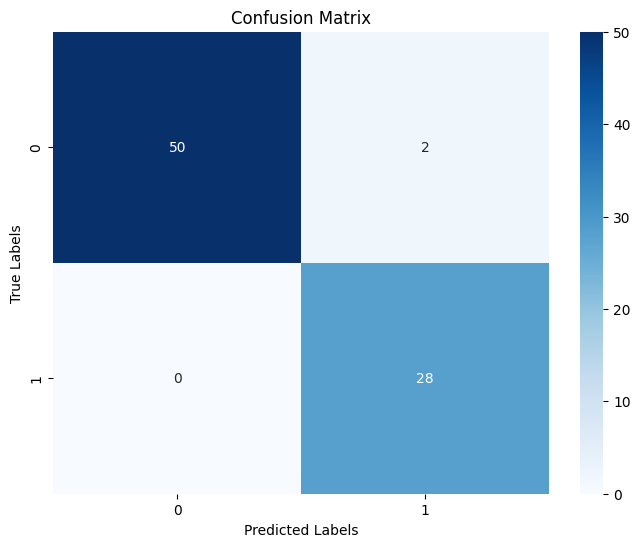

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## find wrong classification

In [ ]:
y_test_list = list(y_test)

In [ ]:
for i in range(len(y_test_list)):
  if y_test_list[i] != y_pred[i]:
    print(y_test_list[i], y_pred[i])

0 1
0 1
